# Portfolio 6
## Portfolio Optimization and the Dow Jones Industrial Average

We attempt to use portfolio optimization techniques to optimize a portfolio consisting of the 30 stocks included in the Dow Jones Industrial Average (DJIA).

## Problem Statement

The Dow Jones Industrial Average (DJIA) is a major stock index consisting of 30 major United States companies spanning a wide range of sectors. It is widely used as an indicator of the overall US stock market, though its accuracy is disputed.  
For this project, we will attempt to optimize a portfolio consisting of the 30 components of the DJIA.  
As in the notes from March 6, we will use `yfinance` for financial data and `cvxpy` to solve the optimization problem.

In [ ]:
# ! pip install cvxpy yfinance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp

The DJIA is listed on Yahoo! Finance under the ticket "^DJI". 
As a stock index, the DJIA index represents a price-weighted measure of the stocks, and does not represent the value of any particular portfolio.  
It is still useful, though, to see the general trend.

In [4]:
dji = yf.Ticker("^DJI")

In [6]:
dji_df = dji.history(period="1y")

In [7]:
dji_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-11 00:00:00-04:00,33586.750000,33781.289062,33586.750000,33684.789062,241430000,0.0,0.0
2023-04-12 00:00:00-04:00,33764.210938,33895.429688,33593.320312,33646.500000,260300000,0.0,0.0
2023-04-13 00:00:00-04:00,33668.968750,34054.988281,33605.171875,34029.691406,277230000,0.0,0.0
2023-04-14 00:00:00-04:00,33981.710938,34082.941406,33730.851562,33886.468750,276720000,0.0,0.0
2023-04-17 00:00:00-04:00,33930.460938,33991.230469,33796.910156,33987.179688,234530000,0.0,0.0


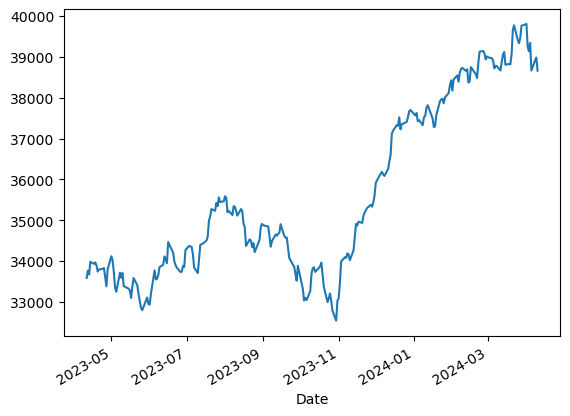

In [8]:
dji_df['Open'].plot()
plt.show()

## Getting the Components

We must manually gather all 30 components individually.
We get the list from https://markets.ft.com/data/indices/tearsheet/constituents?s=DJI:DJI
Code is referenced from the Mar 6 lecture.

In [21]:
T = 1 # days per time period
assets = ['MMM','AMZN','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO',
          'DOW','GS','HD','HON','INTC','IBM','JNJ','JPM','MCD','MRK',
          'MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WMT','DIS']
R = []

for stock in assets:
    data = yf.Ticker(stock)
    df = data.history(period="1y")
    close = df['Close'].values
    returns = (close[T:] - close[:-T])/close[:-T]
    R.append(returns)

R = np.array(R).T
r = np.mean(R,axis=0)
S = np.cov(R.T)

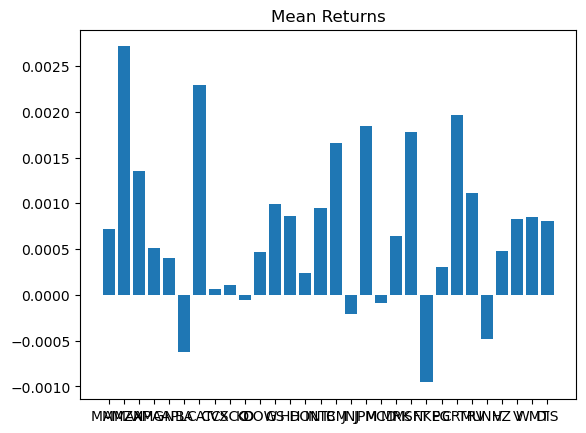

In [9]:
plt.bar(assets, r)
plt.title("Mean Returns")
plt.show()

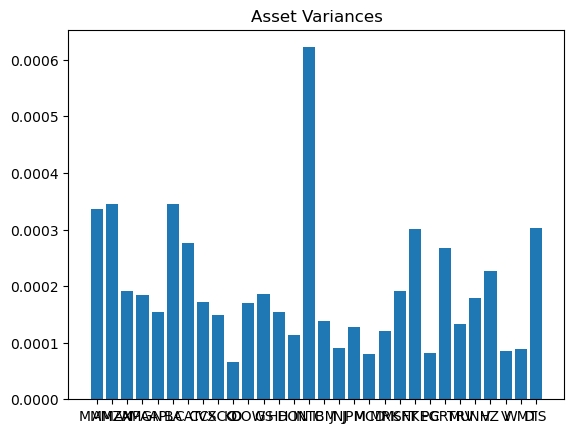

In [4]:
plt.bar(assets, np.diag(S))
plt.title("Asset Variances")
plt.show()

## Simple Strategies

We attempt to optimize the tradeoff between return and risk.  
First, we consider a "naive" strategy: buying every stock in equal proportion.
and buying the stocks proportional to their relative price.

In [11]:
def compute_return_risk(x, r, S):
    avg_return = r.T@x
    risk = x.T@S@x
    print(f'Expected return: {avg_return}')
    print(f'Risk: {risk}')

In [12]:
x_eql = np.ones(30) / 30
compute_return_risk(x_eql, r, S)

Expected return: 0.0006890080880724314
Risk: 4.069342885854396e-05


We compare this to a strategy that buys every stock in proportion to its average return (discarding stocks with negative returns.)

In [29]:
# get raw price of each stock at start of examined period
nonneg_r = np.fmax(0,r) # set weights of negative return stocks to 0
x_prop = nonneg_r / np.sum(nonneg_r)

compute_return_risk(x_prop, r, S)

Expected return: 0.00145055293530129
Risk: 6.26195183315028e-05


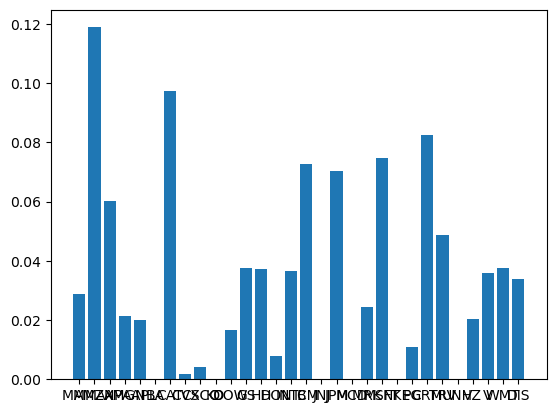

In [30]:
plt.bar(assets, x_prop)
plt.show()

In [31]:
assets[np.argmax(x_prop)]

'AMZN'

The strategy of buying every stock proportional to its price emphasises a few high-performing stocks at the expense of the rest.
The most bought stock is Amazon.

This strategy produces much higher returns, but also much higher risk.
Due to putting most weight into a small selection of higher-performing stocks, this portfolio is less diverse and more risk-prone.

We can also consider buying stocks in inverse proportion to their variance (diagonal entries of S).

In [14]:
x_prop_var = (1 / np.diag(S)) / np.sum(1 / np.diag(S))
compute_return_risk(x_prop_var, r, S)

Expected return: 0.0005786889940453735
Risk: 3.28918082648763e-05


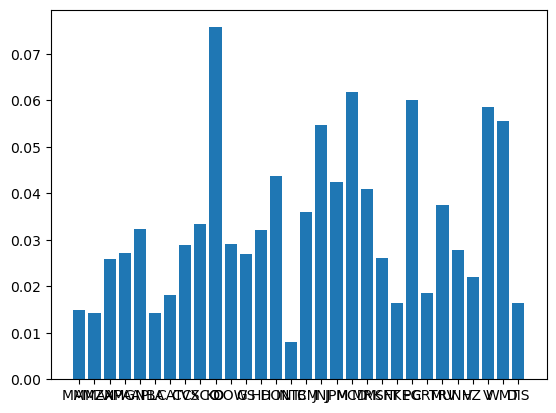

In [24]:
plt.bar(assets, x_prop_var)
plt.show()

In [30]:
assets[np.argmax(x_prop_var)]

'KO'

The risk is much lower, but the payout is also lower.
This strategy is more even but still prioritizes a few stocks over others.
The most bought stock is Coca-Cola.

We will try to beat all three of these strategies by optimizing our returns.

## Optimization Problem

We can try to balance return and risk by using the following formulation:
\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} - q \mathbf{r}^T \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{x} \geq 0 \\
\end{align*}
for some risk tolerance $q > 0$. This formulation was used in the Mar 6 lecture.

We optimize this value for various values of q, and compare with the simple strategies above.
From the values found above, the risk values seem to be about an order of magnitude smaller than the return values.
We test values of q ranging from 0.02 to 0.2, in intervals of 0.02.

In [32]:
n = len(assets)
e = np.ones(n)

qs = np.arange(1,11) * 0.02
optimal_values = []
optimal_returns = []; optimal_risks = []
eql_values = []; prop_values = []; prop_var_values = []


for q in qs:
    eql_values.append(x_eql.T @ S @ x_eql - q * r.T @ x_eql)
    prop_values.append(x_prop.T @ S @ x_prop - q * r.T @ x_prop)
    prop_var_values.append(x_prop_var.T @ S @ x_prop_var - q * r.T @ x_prop_var)
    X = cp.Variable(n)
    obj = cp.Minimize(cp.quad_form(X,S) - q*r@X)
    constraints = [e@X == 1, X >= 0]
    problem = cp.Problem(obj,constraints)
    value = problem.solve()
    optimal_values.append(value)
    optimal_returns.append(r.T @ X.value) 
    optimal_risks.append(X.value.T @ S @ X.value)

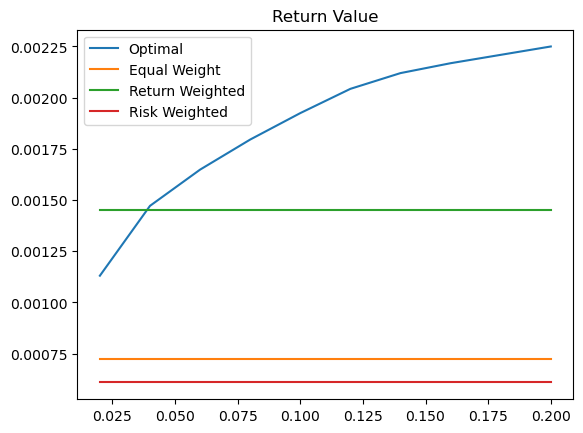

In [36]:
plt.plot(qs, optimal_returns, label="Optimal")
plt.plot(qs, 0.0007218477275418064*np.ones(10), label="Equal Weight")
plt.plot(qs, 0.00145055293530129*np.ones(10), label="Return Weighted")
plt.plot(qs, 0.000609223387153823*np.ones(10), label="Risk Weighted")
plt.legend(); plt.title("Return Value")
plt.show()

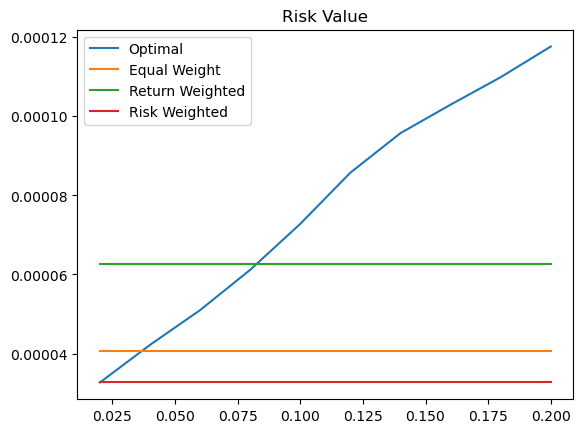

In [37]:
plt.plot(qs, optimal_risks, label="Optimal")
plt.plot(qs, 4.058334334569247e-05*np.ones(10), label="Equal Weight")
plt.plot(qs, 6.26195183315028e-05*np.ones(10), label="Return Weighted")
plt.plot(qs, 3.290039926412654e-05*np.ones(10), label="Risk Weighted")
plt.legend(); plt.title("Risk Value")
plt.show()

In [9]:
# value for q = 0.02
X = cp.Variable(n)
obj = cp.Minimize(cp.quad_form(X,S) - 0.02*r@X)
constraints = [e@X == 1, X >= 0]
problem = cp.Problem(obj,constraints)
value = problem.solve()
print(np.round(X.value,4))

[-0.      0.0555 -0.     -0.      0.      0.      0.0226  0.0137 -0.
  0.      0.     -0.     -0.      0.      0.      0.1218  0.0345  0.132
  0.      0.0745  0.0926  0.      0.0522  0.0121  0.0782  0.0281  0.0337
  0.0306  0.2092  0.0087]


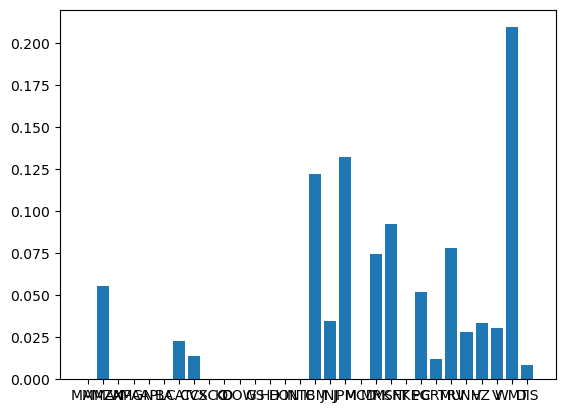

In [8]:
plt.bar(assets, X.value)
plt.show()

In [39]:
# value for q = 0.2
X02 = cp.Variable(n)
obj = cp.Minimize(cp.quad_form(X02,S) - 0.2*r@X02)
constraints = [e@X02 == 1, X02 >= 0]
problem = cp.Problem(obj,constraints)
value = problem.solve()
print(np.round(X02.value, 3))

[ 0.     0.417  0.     0.     0.     0.     0.268  0.     0.     0.
  0.     0.     0.     0.    -0.     0.183  0.     0.131  0.     0.
  0.     0.     0.    -0.     0.     0.     0.     0.     0.    -0.   ]


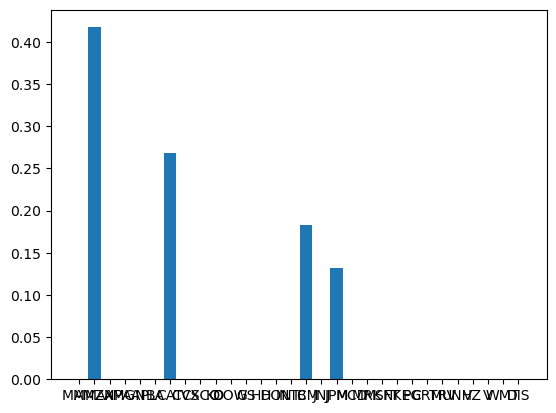

In [40]:
plt.bar(assets, X02.value)
plt.show()

In [20]:
# display the 4 stocks chosen
ndassets = np.array(assets)
nonzero = X02.value > 1e-5
ndassets[nonzero]

array(['AMZN', 'CAT', 'IBM', 'JPM'], dtype='<U4')

In all cases, the optimal solution outperforms the simple strategies by discarding more stocks.  
Even at the low risk tolerance of $q=0.02$, almost half the stocks are discarded, and over 20% of the weight is put into Walmart alone. 
This may indicate that Walmart is a lower-risk stock with acceptable return values.
This strategy matches the risk level of the risk-weighted strategy while offering higher payouts than either the equal-weight or risk-weighed strategies.
Thus, this strategy can be considered to have conclusively "beaten" both strategies, as measured by either value.

At $q=0.2$, the high risk tolerance means all but 4 of the highest performing stocks are discarded.
Over 40% of the weight is put into Amazon (the same stock that was most bought by the return-weighted strategy), with Caterpillar, IBM, and JPMorgan making up the remainder.
This narrow strategy returns much higher returns, but also entails far higher risk due to the lack of diversity in the portfolio: Amazon and IBM are both tech stocks and take up nearly 60% of the weight.

The optimal risk surpasses the risk of the return-weighted strategy around $q = 0.08$, while the optimal return surpasses that of the return-weighted strategy around $q=0.04$.
A q-value in that range would provide a strategy capable of "beating" the return-weighed strategy (higher returns at lower risk).

## References

"Dow Jones Industrial Average". *Financial Times*. The Financial Times Ltd, 12 April 2024, https://markets.ft.com/data/indices/tearsheet/constituents?s=DJI:DJI. Accessed 12 April 2024.

"Dow Jones Industrial Average". *Wikipedia*. Wikimedia Foundation, https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average. Accessed 11 April 2024.

Walls, Patrick. "Portfolio Optimization". Math 441. Mathematical Modelling: Discrete Optimization Problems. 6 March 2024, University of British Columbia. Lecture.  